In [2]:
import cv2
import numpy as np
import operator
from keras.models import load_model
from keras.models import model_from_json
import matplotlib.pyplot as plt
from PIL import ImageDraw,Image,ImageFont

In [3]:
# CNN deep learning model for digits predictions
classifier = load_model("digit_model.h5")

marge = 4    # margin
case = 28 + 2 * marge  # case size
size_grid = 9 * case # grid size
flag=0
# Sudoku game picture
frame = cv2.imread('original.png')

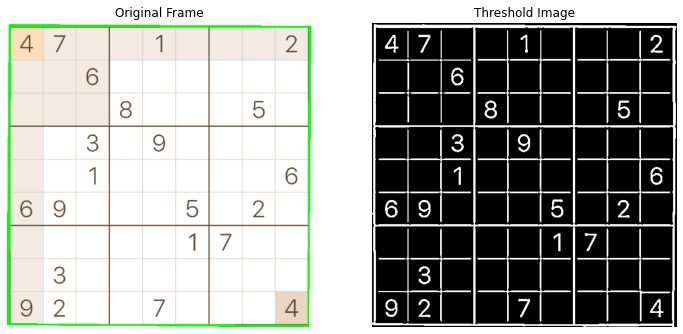

(<matplotlib.image.AxesImage at 0x2e33d7d1a30>,
 (-0.5, 541.5, 540.5, -0.5),
 Text(0.5, 1.0, 'Threshold Image'),
 None)

In [20]:
# Frame Preprocess Tools

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 2)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_grid = None
maxArea = 0

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
cv2.imwrite('solution_pics/thresh.png',cv2.cvtColor(thresh,cv2.COLOR_BGR2RGB))
cv2.imwrite('solution_pics/original.png',cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
ax1.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)),ax1.axis('off'),ax1.set_title('Original Frame')
ax2.imshow(cv2.cvtColor(thresh,cv2.COLOR_BGR2RGB)),ax2.axis('off'),ax2.set_title('Threshold Image'),plt.show()

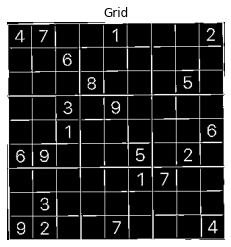

(<matplotlib.image.AxesImage at 0x2e33e064640>,
 (-0.5, 323.5, 323.5, -0.5),
 Text(0.5, 1.0, 'Grid'),
 None)

In [21]:
#Frame Contour Tools
for c in contours:
        area = cv2.contourArea(c)
        if area > 25000:
            peri = cv2.arcLength(c, True)
            polygone = cv2.approxPolyDP(c, 0.01 * peri, True)
            if area > maxArea and len(polygone) == 4:
                contour_grid = polygone
                maxArea = area

cv2.drawContours(frame, [contour_grid], 0, (0, 255, 0), 2)
points = np.vstack(contour_grid).squeeze()
points = sorted(points, key=operator.itemgetter(1))

if points[0][0] < points[1][0]:
  if points[3][0] < points[2][0]:
    pts1 = np.float32([points[0], points[1], points[3], points[2]])
  else:
    pts1 = np.float32([points[0], points[1], points[2], points[3]])

else:
  if points[3][0] < points[2][0]:
    pts1 = np.float32([points[1], points[0], points[3], points[2]])
  else:
    pts1 = np.float32([points[1], points[0], points[2], points[3]])

pts2 = np.float32([[0, 0], [size_grid, 0], [0, size_grid], [size_grid, size_grid]])
M = cv2.getPerspectiveTransform(pts1, pts2)
grid = cv2.warpPerspective(frame, M, (size_grid, size_grid))
grid = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)
grid = cv2.adaptiveThreshold(
grid, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 3)
cv2.imwrite('solution_pics/grid.png',cv2.cvtColor(grid,cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(grid,cv2.COLOR_BGR2RGB)),plt.axis('off'),plt.title('Grid'),plt.show()

In [7]:
# Digit Prediction
if flag == 0:
  grid_vector = []
  
  for y in range(9):
    line = ""
    
    for x in range(9):
        # Find Case.
        y2min = y * case + marge
        y2max = (y + 1) * case - marge
        x2min = x * case + marge
        x2max = (x + 1) * case - marge
        img = grid[y2min:y2max, x2min:x2max]
        case_img = img.reshape(1, 28, 28, 1) # for prediction
        # digit prediction
        if case_img.sum() > 10000:
            predict=classifier.predict(case_img) 
            classes=np.argmax(predict)
            line += "{:d}".format(classes)
        else:
            line += "{:d}".format(0)
    grid_vector.append(line)
    
print(grid_vector) # 0 == space  

['470010002', '006000000', '000800050', '003090000', '001000006', '690005020', '000001700', '030000000', '920070004']


In [10]:
# Predicted digit vector convert to matrix.
split_matrix = []
for row,row_numbers in enumerate(grid_vector):
  try:
    split_rows = list(map(int, row_numbers)) 
  except:
    print(str(row + 1) + "nd line has non-int values.") 

  if len(split_rows) != 9:
    print(str(row + 1) + "nd line has not nine numbers.")

  split_matrix.append(split_rows)
if row != 8:
  print("matrix contains "+ str(row + 1) +"rows instead of 9") 

for_empty =  split_matrix

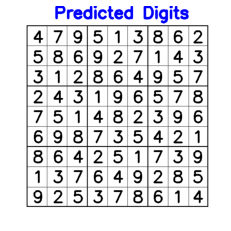

True

In [22]:
#predict digits writing 9x9 sudoku images.
empty = cv2.imread('predicted.jpg')
cv2.putText(empty,'Predicted Digits',(130,33), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 5)
for y in range(0,9):
  for x in range(0,9):
    if for_empty[y][x] != 0:
      location =(70+(55*x),100+(55*y))
      cv2.putText(empty,str(for_empty[y][x]),location, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 3)

plt.imshow(empty),plt.axis('off'),plt.show()
cv2.imwrite('solution_pics/predict_digits.png',cv2.cvtColor(empty,cv2.COLOR_BGR2RGB))

In [15]:
M = 9 # row/column size 

# Sudoku Visualizition Func
def puzzle(a):
    
    for i in range(M):
        for j in range(M):
            print(a[i][j],end = " ")
        print()

# Solve iteration func
def solve(grid, row, col, num):
    
    # query for row
    for x in range(9):
        if grid[row][x] == num:
            return False
    # query for column
    for x in range(9):
        if grid[x][col] == num:
            return False
 
    #query for 3x3 matrix in the game
    startRow = row - row % 3
    startCol = col - col % 3
    for i in range(3):
        for j in range(3):
            if grid[i + startRow][j + startCol] == num:
                return False
    return True
 
# Main function.
def Sudoku(grid, row, col):
 
    if (row == M - 1 and col == M):
        return True
    if col == M:
        row += 1
        col = 0
    if grid[row][col] > 0:
        return Sudoku(grid, row, col + 1)
    for num in range(1, M + 1, 1): 
        
        if solve(grid, row, col, num):
         
            grid[row][col] = num
            if Sudoku(grid, row, col + 1):
                return True
        grid[row][col] = 0
    return False
 

In [16]:
if (Sudoku(split_matrix, 0, 0)):
    puzzle(split_matrix)
else:
    print("Solution does not exist:(")
result=split_matrix

4 7 9 5 1 3 8 6 2 
5 8 6 9 2 7 1 4 3 
3 1 2 8 6 4 9 5 7 
2 4 3 1 9 6 5 7 8 
7 5 1 4 8 2 3 9 6 
6 9 8 7 3 5 4 2 1 
8 6 4 2 5 1 7 3 9 
1 3 7 6 4 9 2 8 5 
9 2 5 3 7 8 6 1 4 


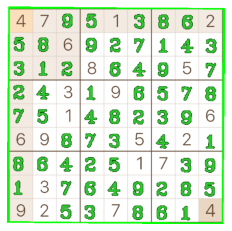

True

In [23]:
flag = 1
fond = np.zeros(shape=(size_grid, size_grid, 3), dtype=np.float32)
for y in range(len(result)):
  for x in range(len(result[y])):
    if grid_vector[y][x] == "0":
      location = ((x) * case + marge + 3, (y + 1) * case - marge - 3)
      cv2.putText(fond, "{:d}".format(result[y][x]),location, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.4, (45, 200, 45), 2)
M = cv2.getPerspectiveTransform(pts2, pts1)
h, w, c = frame.shape
fondP = cv2.warpPerspective(fond, M, (w, h))
img2gray = cv2.cvtColor(fondP, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask = mask.astype('uint8')
mask_inv = cv2.bitwise_not(mask)
img1_bg = cv2.bitwise_and(frame, frame, mask=mask_inv)
img2_fg = cv2.bitwise_and(fondP, fondP, mask=mask).astype('uint8')
dst = cv2.add(img1_bg, img2_fg)
# dst = cv2.resize(dst, (1080, 620))
plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB)),plt.axis('off'),plt.show()
cv2.imwrite('solution_pics/org_solution.png',cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))

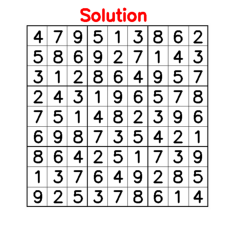

True

In [24]:
cv2.putText(empty,'Predicted Digits',(130,33), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 5)  # empty image restart
cv2.putText(empty,'Solution',(200,40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 5) 
for y in range(0,9):
  for x in range(0,9):
    if for_empty[y][x] == 0:
      # print(str(y) + ',' + str(x))
      location =(70+(55*x),100+(55*y))
      cv2.putText(empty,str(result[y][x]),location, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
    # else:
    #   location =(15+(55*x),45+(55*y))
    #   cv2.putText(empty,str(result[y][x]),location, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 3)
    
plt.imshow(empty),plt.axis('off'),plt.show()
cv2.imwrite('solution_pics/solution.png',cv2.cvtColor(empty,cv2.COLOR_BGR2RGB))